# Crown Tracking — Rotational Shuffles, Connectivity, and Virtual Edges

This notebook extends the conditional-matching tracker with three strategies to improve robustness:

1) Rotational shuffles: run the conditional matcher on all cyclic rotations of the orthomosaic order (e.g., 1-2-3-4, 4-1-2-3, 3-4-1-2, 2-3-4-1). For each node (OM, crown), collect the chains it participates in across rotations and prefer the longest chain (then sort by the true chronological order).

2) Connectivity aggregation: across all rotations, maintain for every node a set of nodes it connects to (union of successors across rotations).

3) Virtual edges: allow edges between non-consecutive OMs (i < j) using the same conditional scoring. Use these to patch nodes with no outgoing edge in the aggregated graph; prioritize candidates consistent with the rotation connectivity.

Outputs include standard quality and complexity metrics plus quick visualizations of the resulting chains.

In [1]:
# Utilities: load the TreeTrackingGraph class from the existing 'good matches only' notebook
import json, os, re, math, random
from collections import defaultdict
from dataclasses import replace
from typing import Any, Dict, List, Optional, Tuple, Iterable, Set

import numpy as np
import geopandas as gpd
import networkx as nx

GOOD_NB = os.path.abspath('../notebooks/crown_tracking_good matches only.ipynb')
FALLBACK_NB = os.path.abspath('../notebooks/crown_tracking_15Oct.ipynb')

def exec_code_from_notebook(nb_path: str, predicate=None) -> int:
    """Execute code cells from a notebook that match a predicate. Returns count of executed cells.
    If predicate is None, executes all code cells."""
    if not os.path.exists(nb_path):
        return 0
    with open(nb_path, 'r') as f:
        nb = json.load(f)
    executed = 0
    for cell in nb.get('cells', []):
        if cell.get('cell_type') != 'code':
            continue
        src = ''.join(cell.get('source', []))
        if (predicate is None) or predicate(src):
            exec(src, globals())
            executed += 1
    return executed

# 1) Load the full TreeTrackingGraph from the 'good matches only' notebook (defines conditional matching, metrics, etc.)
loaded_main = exec_code_from_notebook(GOOD_NB, predicate=lambda s: 'class TreeTrackingGraph' in s or 'MatchCaseConfig' in s)
if not loaded_main:
    raise RuntimeError("Could not load core tracker class from crown_tracking_good matches only.ipynb")

# 2) Load helper methods from the 15Oct notebook for custom order and virtual edges if available
_ = exec_code_from_notebook(FALLBACK_NB, predicate=lambda s: 'def build_graph_conditional_for_order' in s)
_ = exec_code_from_notebook(FALLBACK_NB, predicate=lambda s: 'def build_graph_virtual_allpairs' in s and 'enhanced' not in s)

# Sanity: ensure required methods are bound on TreeTrackingGraph
req_methods = ['build_graph_conditional_for_order']
for m in req_methods:
    if not hasattr(TreeTrackingGraph, m):
        raise RuntimeError(f"Missing required method: {m}.")

print('Loaded TreeTrackingGraph and helper methods.')

Loaded TreeTrackingGraph and helper methods.


In [2]:
# Rotational orders and aggregation helpers
from itertools import islice

def rotational_orders(seq: List[int]) -> List[List[int]]:
    n = len(seq)
    return [seq[i:] + seq[:i] for i in range(n)]

def collect_rotation_results(base_tracker: TreeTrackingGraph, *, base_max_dist: float = 75.0, overlap_gate: float = 0.48, min_base_similarity: float = 0.35) -> Dict[str, Any]:
    """For each cyclic rotation, build a graph and accumulate:
    - edge_counts[(u,v)] = times seen across rotations
    - connectivity[u] = set of successors across rotations
    - chains_by_node[u] = list of chains that include node u (as lists of nodes)
    Returns a dict with aggregated artifacts and per-rotation trackers.
    """
    orders = rotational_orders(base_tracker.om_ids)
    edge_counts: Dict[Tuple[Tuple[int,int], Tuple[int,int]], int] = defaultdict(int)
    connectivity: Dict[Tuple[int,int], Set[Tuple[int,int]]] = defaultdict(set)
    chains_by_node: Dict[Tuple[int,int], List[List[Tuple[int,int]]]] = defaultdict(list)
    rotation_graphs: List[TreeTrackingGraph] = []

    for order in orders:
        temp = TreeTrackingGraph(auto_discover=False)
        # share data
        temp.crown_dir = base_tracker.crown_dir
        temp.ortho_dir = base_tracker.ortho_dir
        temp.file_pairs = list(base_tracker.file_pairs)
        temp.om_ids = list(base_tracker.om_ids)
        temp.crowns_gdfs = base_tracker.crowns_gdfs
        temp.crown_attrs = base_tracker.crown_attrs
        temp.crown_images = base_tracker.crown_images
        temp.case_configs = {name: replace(cfg) for name, cfg in base_tracker.case_configs.items()}
        temp.case_order = list(base_tracker.case_order)
        temp.build_graph_conditional_for_order(order, base_max_dist=base_max_dist, overlap_gate=overlap_gate, min_base_similarity=min_base_similarity)
        rotation_graphs.append(temp)
        # accumulate edges and connectivity
        for u, v in temp.G.edges():
            edge_counts[(u, v)] += 1
            connectivity[u].add(v)
        # chains
        chains = temp._extract_all_chains()
        for ch in chains:
            for n in ch:
                chains_by_node[n].append(ch)
    return {
        'orders': orders,
        'edge_counts': edge_counts,
        'connectivity': connectivity,
        'chains_by_node': chains_by_node,
        'rotation_graphs': rotation_graphs,
    }

def build_aggregated_graph_from_rotations(base_tracker: TreeTrackingGraph, agg: Dict[str, Any], *, min_frequency: float = 0.5) -> TreeTrackingGraph:
    """Create a new tracker graph keeping edges seen in >= min_frequency of rotations.
    Returns a new tracker instance with shared nodes and filtered edges.
    """
    orders = agg['orders']
    edge_counts = agg['edge_counts']
    k = len(orders)
    keep_min = max(1, int(math.ceil(min_frequency * k)))
    out = TreeTrackingGraph(auto_discover=False)
    # share data
    out.crown_dir = base_tracker.crown_dir
    out.ortho_dir = base_tracker.ortho_dir
    out.file_pairs = list(base_tracker.file_pairs)
    out.om_ids = list(base_tracker.om_ids)
    out.crowns_gdfs = base_tracker.crowns_gdfs
    out.crown_attrs = base_tracker.crown_attrs
    out.crown_images = base_tracker.crown_images
    out.reset_graph()
    # add nodes
    for om_id in out.om_ids:
        gdf = out.crowns_gdfs[om_id]
        for crown_id, _ in gdf.iterrows():
            out.G.add_node((om_id, crown_id), **out.crown_attrs[om_id][crown_id])
    # add edges by frequency
    for (u, v), c in edge_counts.items():
        if c >= keep_min:
            out.G.add_edge(u, v, method='rotation_agg', agg_count=int(c), similarity=float(base_tracker.G.get_edge_data(u, v, {}).get('similarity', 0.0)))
    return out

def choose_longest_chain_per_node(base_tracker: TreeTrackingGraph, agg: Dict[str, Any]) -> Dict[Tuple[int,int], List[Tuple[int,int]]]:
    """For each node, pick the longest chain it appears in across rotations;
    then sort by actual chronological order (ascending OM id).
    Returns mapping node -> chain (list of nodes).
    """
    result: Dict[Tuple[int,int], List[Tuple[int,int]]] = {}
    for node, chains in agg['chains_by_node'].items():
        if not chains:
            continue
        best = max(chains, key=lambda c: len(c))
        # sort chain nodes by true OM order
        best_sorted = sorted(best, key=lambda n: base_tracker.om_ids.index(n[0]))
        result[node] = best_sorted
    return result

In [3]:
# Virtual edge supplementation: use non-consecutive matches to patch missing links
def supplement_with_virtual_edges(base_tracker: TreeTrackingGraph, agg_tracker: TreeTrackingGraph, *, overlap_gate: float = 0.48, base_max_dist: float = 75.0, min_base_similarity: float = 0.35, connectivity: Optional[Dict[Tuple[int,int], Set[Tuple[int,int]]]] = None) -> None:
    """For nodes with no outgoing edge, propose a virtual edge to later OMs using the same conditional matcher.
    Prefer virtual targets seen among connectivity[u] (neighbors across rotations). Enforce 1 out, 1 in.
    Mutates agg_tracker.G in place.
    """
    # Build a separate graph of virtual all-pairs to get candidates
    virt = TreeTrackingGraph(auto_discover=False)
    # share data
    virt.crown_dir = base_tracker.crown_dir
    virt.ortho_dir = base_tracker.ortho_dir
    virt.file_pairs = list(base_tracker.file_pairs)
    virt.om_ids = list(base_tracker.om_ids)
    virt.crowns_gdfs = base_tracker.crowns_gdfs
    virt.crown_attrs = base_tracker.crown_attrs
    virt.crown_images = base_tracker.crown_images
    # Ensure virtual-allpairs exists (loaded from 15Oct); if not, do nothing
    if not hasattr(TreeTrackingGraph, 'build_graph_virtual_allpairs'):
        print('Virtual-all-pairs method not available; skipping virtual supplementation.')
        return
    virt.build_graph_virtual_allpairs(base_max_dist=base_max_dist, overlap_gate=overlap_gate, min_base_similarity=min_base_similarity)

    used_in: Set[Tuple[int,int]] = set(v for _, v in agg_tracker.G.edges())
    # Consider only nodes without outgoing edge
    for u in list(agg_tracker.G.nodes()):
        if agg_tracker.G.out_degree(u) > 0:
            continue
        # collect virtual candidates sorted by similarity
        cands = []
        for _, v, d in virt.G.out_edges(u, data=True):
            cands.append((v, float(d.get('similarity', 0.0)), d))
        if not cands:
            continue
        cands.sort(key=lambda x: x[1], reverse=True)
        pref = set(connectivity.get(u, set())) if connectivity else set()
        # pick first candidate with free in-degree and, if possible, present in connectivity set
        chosen = None
        for v, sim, d in cands:
            if v in used_in:
                continue
            chosen = (v, sim, d)
            if v in pref:
                break
        if chosen:
            v, sim, d = chosen
            agg_tracker.G.add_edge(u, v, similarity=float(sim), method='virtual_patch', case=d.get('case', 'one_to_one'), iou=float(d.get('iou', 0.0)), overlap_prev=float(d.get('overlap_prev', 0.0)), overlap_curr=float(d.get('overlap_curr', 0.0)))
            used_in.add(v)

print('Virtual supplementation ready.')

Virtual supplementation ready.


In [4]:
# Detailed matching metrics (adapted from 15Oct notebook)
def compute_detailed_matching_metrics(tracker: TreeTrackingGraph) -> Dict[str, Any]:
    G = tracker.G
    om_ids = tracker.om_ids
    out: Dict[str, Any] = {}
    out['num_nodes'] = G.number_of_nodes()
    out['num_edges'] = G.number_of_edges()
    by_case: Dict[str, int] = defaultdict(int)
    by_gap: Dict[int, int] = defaultdict(int)
    sim_values: List[float] = []
    iou_values: List[float] = []
    for u, v, d in G.edges(data=True):
        by_case[d.get('case', d.get('method','unknown'))] += 1
        gap = (tracker.om_ids.index(v[0]) - tracker.om_ids.index(u[0]))
        by_gap[gap] += 1
        sim_values.append(float(d.get('similarity', 0.0)))
        iou_values.append(float(d.get('iou', 0.0)))
    out['edges_by_case'] = dict(sorted(by_case.items(), key=lambda kv: (-kv[1], kv[0])))
    out['edges_by_gap'] = dict(sorted(by_gap.items()))
    def _stats(vals: List[float]) -> Dict[str, float]:
        if not vals:
            return {'count': 0, 'mean': 0.0, 'median': 0.0, 'min': 0.0, 'max': 0.0}
        return {'count': len(vals), 'mean': float(np.mean(vals)), 'median': float(np.median(vals)), 'min': float(np.min(vals)), 'max': float(np.max(vals))}
    out['similarity_stats'] = _stats(sim_values)
    out['iou_stats'] = _stats(iou_values)
    # Pair stats for consecutive OMs
    pair_stats: Dict[str, Dict[str, float]] = {}
    for i in range(len(om_ids) - 1):
        om1, om2 = om_ids[i], om_ids[i + 1]
        om1_nodes = [n for n in G.nodes if n[0] == om1]
        om2_nodes = [n for n in G.nodes if n[0] == om2]
        matches = sum(1 for u, v in G.edges() if u[0] == om1 and v[0] == om2)
        possible = min(len(om1_nodes), len(om2_nodes))
        rate = matches / possible if possible > 0 else 0.0
        pair_stats[f"{om1}->{om2}"] = {'matches': matches, 'possible': possible, 'rate': float(rate)}
    out['pair_stats'] = pair_stats
    # Chains
    chains = tracker._extract_all_chains()
    lengths = [len(c) for c in chains]
    out['chain_count'] = len(chains)
    out['chain_length_stats'] = {'count': len(lengths), 'mean': float(np.mean(lengths)) if lengths else 0.0, 'median': float(np.median(lengths)) if lengths else 0.0, 'min': float(np.min(lengths)) if lengths else 0.0, 'max': float(np.max(lengths)) if lengths else 0.0}
    return out

In [6]:
# Run the full pipeline: load data, rotational aggregation, virtual supplementation, metrics
tracker = TreeTrackingGraph()
tracker.load_data(load_images=False)

agg = collect_rotation_results(tracker, base_max_dist=75.0, overlap_gate=0.48, min_base_similarity=0.35)
rot_graph = build_aggregated_graph_from_rotations(tracker, agg, min_frequency=0.5)

# Prefer longest chain per node (kept for inspection)
best_chain_for_node = choose_longest_chain_per_node(tracker, agg)

# Patch with virtual edges for nodes lacking out-edges
supplement_with_virtual_edges(tracker, rot_graph, overlap_gate=0.48, base_max_dist=75.0, min_base_similarity=0.35, connectivity=agg['connectivity'])

# Metrics
q_report, q = rot_graph.quality_report()
c_report, c = rot_graph.complexity_report()
d = compute_detailed_matching_metrics(rot_graph)
print(q_report)
print('---')
print(c_report)
print('---')
print('Edges by case:', d['edges_by_case'])
print('Edges by gap:', d['edges_by_gap'])
print('Similarity stats:', d['similarity_stats'])
print('IoU stats:', d['iou_stats'])

# Save artifacts
rot_graph.save_text(q_report, 'rotational_agg_quality_report.txt')
rot_graph.save_json(q, 'rotational_agg_quality_metrics.json')
rot_graph.save_text(c_report, 'rotational_agg_complexity_report.txt')
rot_graph.save_json(c, 'rotational_agg_complexity_metrics.json')
rot_graph.save_json(d, 'rotational_agg_detailed_matching_metrics.json')
print('Saved reports to', rot_graph.output_dir)

# Tree Tracking Quality Assessment Report

Total Trees Detected: 626
Total Tracking Edges: 98
Overall Match Rate: 0.107
Average Chain Length: 1.16
Maximum Chain Length: 4

Match Rates by Orthomosaic Pair:
- 1->2: 9/80 (0.113)
- 2->3: 11/116 (0.095)
- 3->4: 17/130 (0.131)
- 4->5: 14/150 (0.093)

Chain Length Distribution:
- Length 1: 465 trees
- Length 2: 65 trees
- Length 3: 9 trees
- Length 4: 1 trees
---
# Graph Complexity Report

Nodes: 626
Edges: 98
Avg out-degree: 0.157
Avg in-degree: 0.157
Zero out-degree nodes: 528
Zero in-degree nodes: 528
Weakly connected components: 534 (sizes head: [4, 3, 3, 3, 3, 3, 3, 3, 3, 3])
Strongly connected components: 620 (sizes head: [2, 2, 2, 2, 2, 2, 1, 1, 1, 1])
Average diameter: 0.172
Median diameter: 0.000
Max diameter: 3
---
Edges by case: {'rotation_agg': 58, 'partial_overlap': 30, 'merge': 4, 'one_to_one': 4, 'split': 2}
Edges by gap: {-4: 7, 1: 51, 2: 18, 3: 15, 4: 7}
Similarity stats: {'count': 98, 'mean': 0.2807350668393592, 'median': 0.

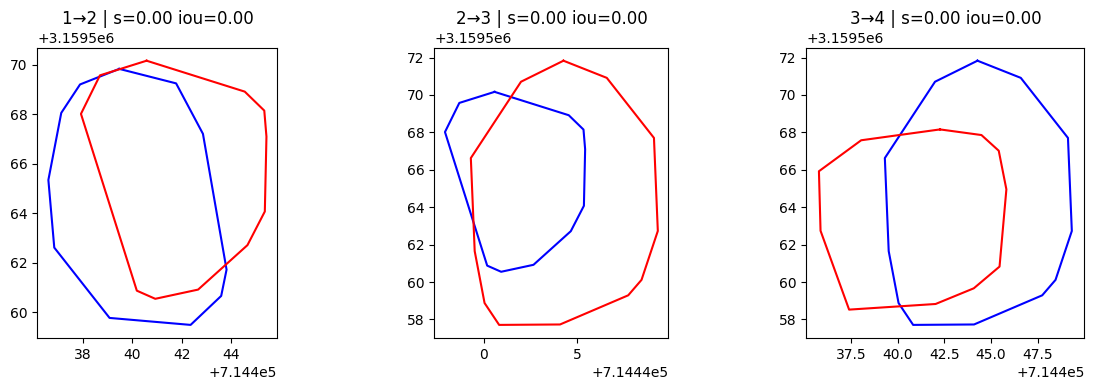

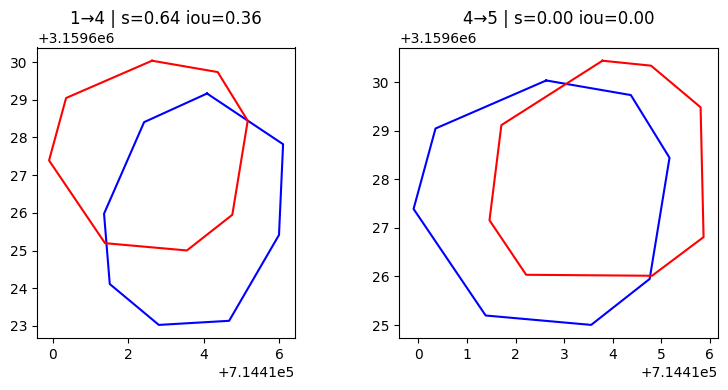

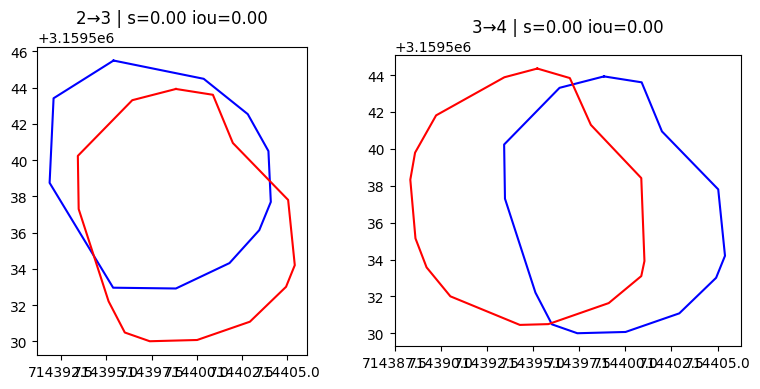

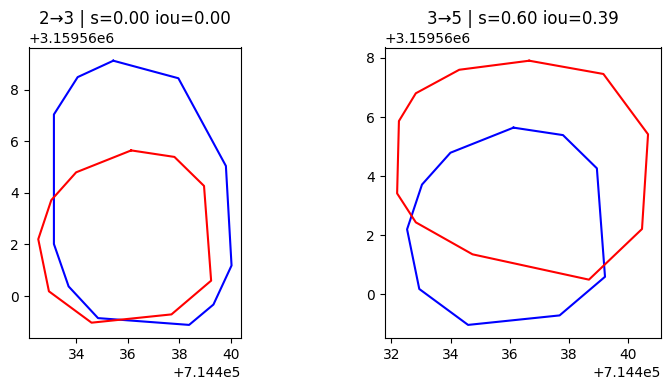

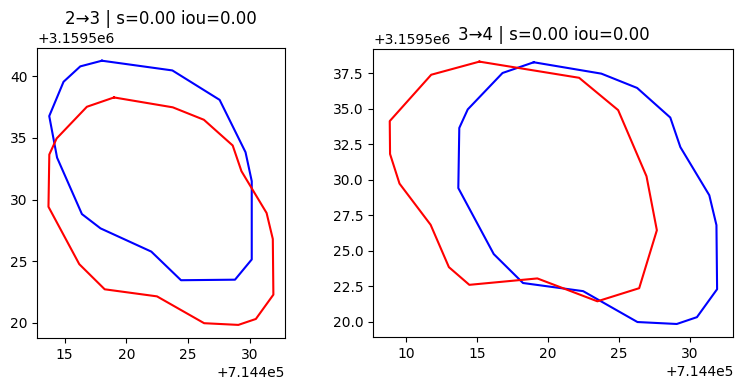

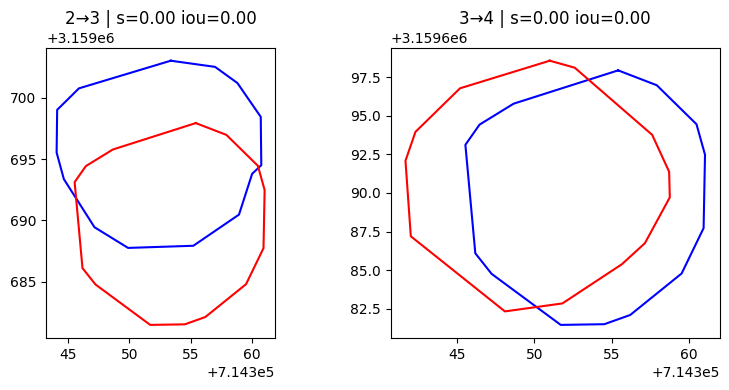

In [7]:
# Quick visualization: show top-N longest chains
import matplotlib.pyplot as plt

def visualize_top_chains(tracker: TreeTrackingGraph, k: int = 5):
    chains = tracker._extract_all_chains()
    chains = sorted([c for c in chains if len(c) >= 2], key=lambda c: len(c), reverse=True)[:k]
    for idx, ch in enumerate(chains, 1):
        fig, axes = plt.subplots(1, len(ch)-1, figsize=(4*max(1,len(ch)-1), 4))
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])
        for ax, (u, v) in zip(axes, zip(ch, ch[1:])):
            ug = tracker.G.nodes[u]['geometry']; vg = tracker.G.nodes[v]['geometry']
            try:
                ux, uy = ug.exterior.xy
                vx, vy = vg.exterior.xy
            except Exception:
                continue
            ax.plot(ux, uy, 'b-'); ax.plot(vx, vy, 'r-')
            e = tracker.G.get_edge_data(u, v) or {}
            ax.set_title(f"{u[0]}→{v[0]} | s={e.get('similarity',0):.2f} iou={e.get('iou',0):.2f}")
            ax.set_aspect('equal', 'box')
        plt.tight_layout(); plt.show()

visualize_top_chains(rot_graph, k=6)